In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
import re
# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bert model and tokenizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# for handling data loading and batching.
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

'''
# Import packages for data modeling
import sagemaker
import sys
import boto3
from time import gmtime, strftime
from pathlib import Path

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = boto3.Session()
sm = sess.client('sagemaker')
'''


"\n# Import packages for data modeling\nimport sagemaker\nimport sys\nimport boto3\nfrom time import gmtime, strftime\nfrom pathlib import Path\n\nsagemaker_session = sagemaker.Session()\nrole = sagemaker.get_execution_role()\nregion = boto3.Session().region_name\nsess = boto3.Session()\nsm = sess.client('sagemaker')\n"

In [86]:
# cell used previously in aws sagemaker but had to transition back to colab to reduce costs
'''
s3 = boto3.resource('s3')
for buckets in s3.buckets.all():
    if 'aws1sentiment' in buckets.name:
        bucket = buckets.name
print("Bucket: ", bucket)
prefix = 'data'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# Configure the training paths
train_path = f"s3://{bucket}/{prefix}/twitter_training.csv"
validation_path = f"s3://{bucket}/{prefix}/twitter_validation.csv"
print(train_path)
print(validation_path)
print('s3://aws1sentiment/data/twitter_training.csv')'''



'\ns3 = boto3.resource(\'s3\')\nfor buckets in s3.buckets.all():\n    if \'aws1sentiment\' in buckets.name:\n        bucket = buckets.name\nprint("Bucket: ", bucket)\nprefix = \'data\'\noutput_path = \'s3://{}/{}/output\'.format(bucket, prefix)\n\n# Configure the training paths\ntrain_path = f"s3://{bucket}/{prefix}/twitter_training.csv"\nvalidation_path = f"s3://{bucket}/{prefix}/twitter_validation.csv"\nprint(train_path)\nprint(validation_path)\nprint(\'s3://aws1sentiment/data/twitter_training.csv\')'

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
data_train = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/twitter_training.csv', header= None)
data_val = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/twitter_validation.csv', header= None)
data_train = data_train.rename(columns = {0: 'tweetID', 1:'entity', 2:'sentiment', 3:'tweet_text'})
data_val = data_val.rename(columns = {0: 'tweetID', 1:'entity', 2:'sentiment', 3:'tweet_text'})

data_train.head()

,tweetID,entity,sentiment,tweet_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [89]:
print(data_train.shape)
print(data_val.shape)

(74682, 4)
(1000, 4)


In [90]:
data_val = data_val.rename(columns = {0: 'tweetID', 1:'entity', 2:'sentiment', 3:'tweet_text'})
data_val.head()

,tweetID,entity,sentiment,tweet_text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [91]:
data_val = data_val.drop(columns=['tweetID'])
data_train = data_train.drop(columns=['tweetID'])
data_val['sentiment'] = data_val['sentiment'].replace('Irrelevant', 'Neutral')
data_train['sentiment'] = data_train['sentiment'].replace('Irrelevant', 'Neutral')

print('validation:',data_val['sentiment'].value_counts())
print('training:',data_train['sentiment'].value_counts())


validation: sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64
training: sentiment
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64


In [92]:
# this step is due to use extracting half of the neutral labels for inital model traingin
# we will replicate the same owrk doen and ensure that we're not using the sasme labels again
neutral_df = data_train[data_train['sentiment']=='Neutral']
neutral_df = neutral_df.sample(frac=1, random_state=42).reset_index(drop=False)
half_size = len(neutral_df) // 2

neutral_half_1 = neutral_df.iloc[:half_size]#will be added to the first dataset

neutral_half_2 = neutral_df.iloc[half_size:]#will be kept in the entity dataset for fine tuning
d_train = data_train.drop(neutral_half_1['index'])
d_train = d_train.reset_index(drop=True)

print(d_train['sentiment'].value_counts())
print(neutral_half_1['sentiment'].value_counts())
print(neutral_half_1.head())

sentiment
Negative    22542
Positive    20832
Neutral     15654
Name: count, dtype: int64
sentiment
Neutral    15654
Name: count, dtype: int64
   index        entity sentiment  \
0   7741     Overwatch   Neutral   
1  18890  WorldOfCraft   Neutral   
2  29545   ApexLegends   Neutral   
3  50793          FIFA   Neutral   
4  54957    CallOfDuty   Neutral   

                                          tweet_text  
0  Fun with friends (maybe a few mates... maybe)....  
1  Review: 'In Love and Warcraft' Serves Romance ...  
2  Two whole minutes could not even capture my fa...  
3  How the fuck does FIFA expect you to win again...  
4  she can sleep through me yelling for hours on ...  


In [93]:
d_val = data_val
print(d_val['sentiment'].value_counts())

sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64


In [94]:
print(d_train['sentiment'].value_counts()/d_train['sentiment'].shape[0]*100)
print(d_val['sentiment'].value_counts()/d_val['sentiment'].shape[0]*100)


sentiment
Negative    38.188656
Positive    35.291726
Neutral     26.519618
Name: count, dtype: float64
sentiment
Neutral     45.7
Positive    27.7
Negative    26.6
Name: count, dtype: float64


balancing the validation with the training dataset

In [95]:
sampled_rows = d_train[
    (d_train['sentiment'] == 'Positive') | (d_train['sentiment'] == 'Negative')
].sample(n=400, random_state=42)
sampled_rows['sentiment'].value_counts()

,count
sentiment,
Negative,207
Positive,193


In [96]:
missing_indices = sampled_rows.index.difference(d_train.index)


In [97]:

d_train = d_train.drop(sampled_rows.index)
d_val = pd.concat([d_val, sampled_rows],ignore_index=True)
d_train = d_train.reset_index(drop=True)
d_val = d_val.reset_index(drop=True)
print(d_train['sentiment'].value_counts())
print(d_val['sentiment'].value_counts())


sentiment
Negative    22335
Positive    20639
Neutral     15654
Name: count, dtype: int64
sentiment
Negative    473
Positive    470
Neutral     457
Name: count, dtype: int64


In [98]:
d_train.head()

,entity,sentiment,tweet_text
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [99]:
data_train['entity'].value_counts()
print(len(data_train['entity'].value_counts()))


32


In [100]:
def preProcess(text):
  if not isinstance(text, str):
    return""

  text = text.lower()
  text = re.sub(r'http\S+|WWW\S+|https\S+', '[URL]',text)
  text = re.sub(r'@\w+', '[USER]', text)

  text = re.sub(r'\s+', ' ', text).strip()

  return text
d_train['clean_text'] = d_train['tweet_text'].apply(preProcess)
d_train[['clean_text','tweet_text']]


,clean_text,tweet_text
0,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,i am coming to the borders and i will kill you...,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...
...,...,...
58623,just realized that the windows partition of my...,Just realized that the Windows partition of my...
58624,just realized that my mac window partition is ...,Just realized that my Mac window partition is ...
58625,just realized the windows partition of my mac ...,Just realized the windows partition of my Mac ...
58626,just realized between the windows partition of...,Just realized between the windows partition of...


In [101]:
X = d_train['clean_text']
y = d_train['sentiment']
y = y.map({'Positive': 2, 'Negative': 0, 'Neutral': 1})
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y,random_state=42)


In [102]:
y.value_counts()

,count
sentiment,
0,22335
2,20639
1,15654


In [103]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [104]:
def tokenize_texts(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Adds [CLS] and [SEP]
            max_length=max_len,
            padding='max_length',         # Pads to the max_length
            truncation=True,              # Truncates texts longer than max_length
            return_attention_mask=True,   # Generates attention masks
            return_tensors='pt'           # Returns PyTorch tensors
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [105]:
train_input_ids, train_attention_masks = tokenize_texts(x_train, tokenizer)
test_input_ids, test_attention_masks = tokenize_texts(x_test, tokenizer)


In [106]:

y_train_f = torch.tensor(y_train.values)
y_test_f = torch.tensor(y_test.values)

In [107]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks,y_train_f)
test_dataset = TensorDataset(test_input_ids, test_attention_masks,y_test_f)

batch_size = 64
# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Samples data randomly
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),  # Samples data sequentially
    batch_size=batch_size
)

In [108]:
import os
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm  # For progress bars


In [ ]:
# Load the model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Load the saved model weights
checkpoint = torch.load('/content/drive/MyDrive/KaggleDatasets/checkpoint_epoch_2.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-109-bb30a6ec0b7c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

<All keys matched successfully>

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [111]:
# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Set up the learning rate scheduler
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # Warm-up for 10% of steps
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [112]:
def train_with_early_stopping(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10, patience=2):
    training_stats = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 20)

        # Training
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in tqdm(train_dataloader, desc='Training'):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            total_train_accuracy += (preds == b_labels).sum().item()

            # Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Average training accuracy: {avg_train_accuracy:.4f}")

        # Validation
        model.eval()
        total_eval_loss = 0
        total_eval_accuracy = 0

        for batch in tqdm(val_dataloader, desc='Validation'):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels
                )
            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_eval_accuracy += (preds == b_labels).sum().item()

        avg_val_loss = total_eval_loss / len(val_dataloader)
        avg_val_accuracy = total_eval_accuracy / len(val_dataloader.dataset)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {avg_val_accuracy:.4f}")

        # Record statistics
        training_stats.append({
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy': avg_train_accuracy,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy
        })

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model_state.bin')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered.')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_state.bin'))

    return training_stats


In [113]:
training_stats = train_with_early_stopping(
    model,
    train_dataloader,
    val_dataloader=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    patience=2
)

output_dir = '/content/drive/MyDrive/KaggleDatasets/finetuned_model/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
model.save_pretrained(output_dir)

# Save tokenizer if you have it defined
# tokenizer.save_pretrained(output_dir)

# Optionally, save the optimizer and scheduler state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict()
}, os.path.join(output_dir, 'checkpoint.pth'))



Epoch 1/10
--------------------


Training: 100%|██████████| 733/733 [15:10<00:00,  1.24s/it]


Average training loss: 0.8808
Average training accuracy: 0.6910


Validation: 100%|██████████| 184/184 [01:23<00:00,  2.21it/s]


Validation Loss: 0.5212
Validation Accuracy: 0.7919

Epoch 2/10
--------------------


Training: 100%|██████████| 733/733 [15:06<00:00,  1.24s/it]


Average training loss: 0.3974
Average training accuracy: 0.8456


Validation: 100%|██████████| 184/184 [01:22<00:00,  2.22it/s]


Validation Loss: 0.3981
Validation Accuracy: 0.8464

Epoch 3/10
--------------------


Training: 100%|██████████| 733/733 [15:07<00:00,  1.24s/it]


Average training loss: 0.2426
Average training accuracy: 0.9073


Validation: 100%|██████████| 184/184 [01:23<00:00,  2.21it/s]


Validation Loss: 0.3788
Validation Accuracy: 0.8632

Epoch 4/10
--------------------


Training: 100%|██████████| 733/733 [15:08<00:00,  1.24s/it]


Average training loss: 0.2017
Average training accuracy: 0.9237


Validation: 100%|██████████| 184/184 [01:22<00:00,  2.22it/s]


Validation Loss: 0.3788
Validation Accuracy: 0.8632

Epoch 5/10
--------------------


Training: 100%|██████████| 733/733 [15:06<00:00,  1.24s/it]


Average training loss: 0.2008
Average training accuracy: 0.9231


Validation: 100%|██████████| 184/184 [01:22<00:00,  2.22it/s]
<ipython-input-112-f6ed0ee3c09d>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

Validation Loss: 0.3788
Validation Accuracy: 0.8632
Early stopping triggered.


In [114]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(dataloader, desc='Evaluating'):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask
            )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

    print(classification_report(true_labels, predictions, digits=4))

# Run evaluation
evaluate(model, test_dataloader)


Evaluating: 100%|██████████| 184/184 [01:23<00:00,  2.20it/s]

              precision    recall  f1-score   support

           0     0.8693    0.9053    0.8869      4467
           1     0.8663    0.7761    0.8187      3131
           2     0.8545    0.8837    0.8689      4128

    accuracy                         0.8632     11726
   macro avg     0.8634    0.8550    0.8582     11726
weighted avg     0.8633    0.8632    0.8624     11726



<ipython-input-115-b32c28d54d43>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


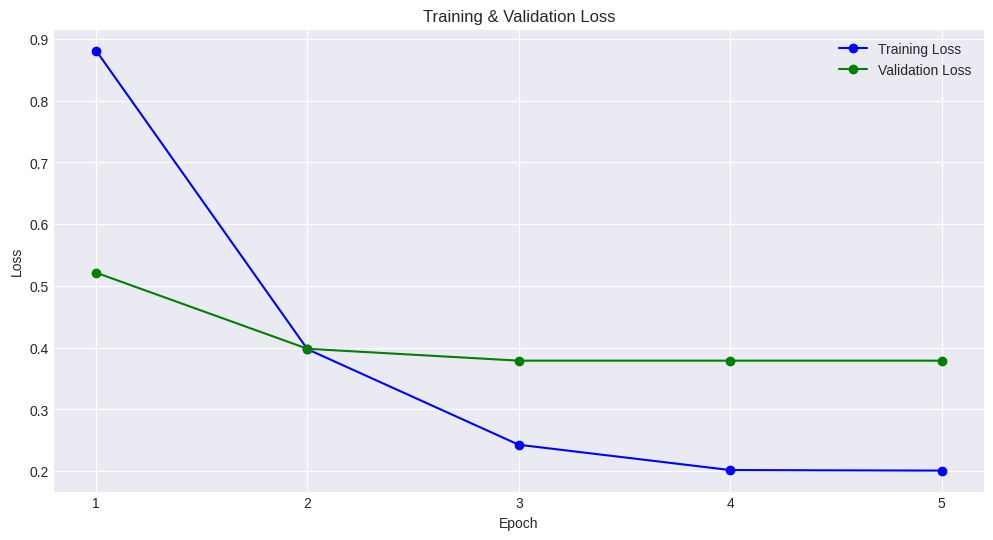

In [115]:
# Convert to DataFrame
df_stats = pd.DataFrame(training_stats)
# Set the style
plt.style.use('seaborn-darkgrid')

# Increase the size of plots
plt.rcParams["figure.figsize"] = (12,6)

# Plot Loss
plt.plot(df_stats['epoch'], df_stats['Training Loss'], 'b-o', label='Training Loss')
plt.plot(df_stats['epoch'], df_stats['Validation Loss'], 'g-o', label='Validation Loss')

# Label the plot
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(df_stats['epoch'])

plt.show()


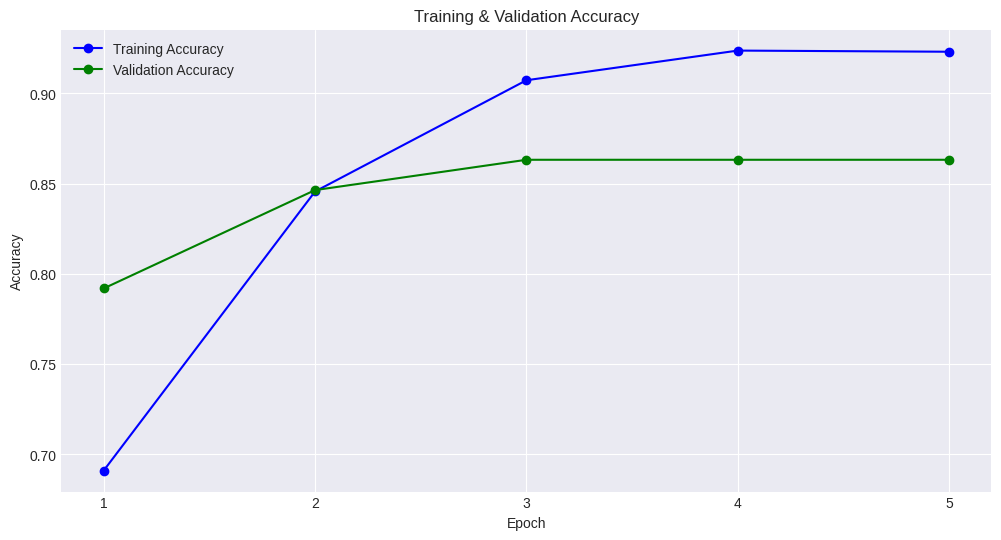

In [116]:
# Plot Accuracy
plt.plot(df_stats['epoch'], df_stats['Training Accuracy'], 'b-o', label='Training Accuracy')
plt.plot(df_stats['epoch'], df_stats['Validation Accuracy'], 'g-o', label='Validation Accuracy')

# Label the plot
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(df_stats['epoch'])

plt.show()


Evaluating for Confusion Matrix: 100%|██████████| 184/184 [01:23<00:00,  2.22it/s]


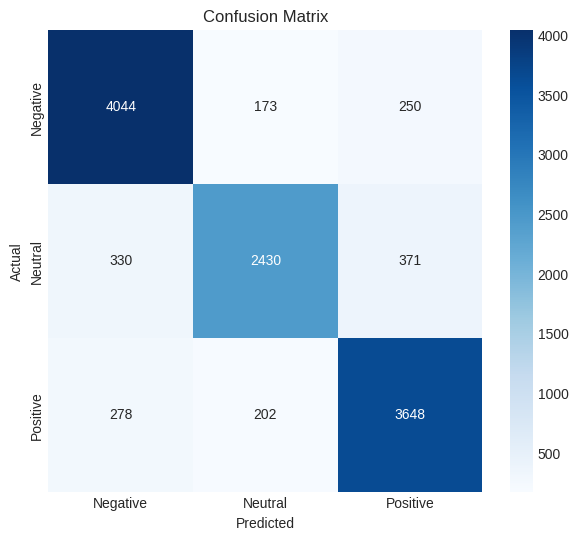

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(dataloader, desc='Evaluating for Confusion Matrix'):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask
            )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['Negative', 'Neutral', 'Positive']  # Adjust if your labels are different
plot_confusion_matrix(model, test_dataloader, class_names)


# Testing the model on unseen data

In [118]:
d_val['clean_text'] = d_val['tweet_text'].apply(preProcess)
d_val[['clean_text','tweet_text']]


,clean_text,tweet_text
0,i mentioned on facebook that i was struggling ...,I mentioned on Facebook that I was struggling ...
1,bbc news - amazon boss jeff bezos rejects clai...,BBC News - Amazon boss Jeff Bezos rejects clai...
2,[USER] why do i pay for word when it functions...,@Microsoft Why do I pay for WORD when it funct...
3,"csgo matchmaking is so full of closet hacking,...","CSGO matchmaking is so full of closet hacking,..."
4,now the president is slapping americans in the...,Now the President is slapping Americans in the...
...,...,...
1395,". . the ""awesome""",". . The ""awesome"""
1396,. laura tells [USER]: ginger is nice to fortni...,. Laura tells @GOLFTV: Ginger is nice to Fortn...
1397,"i hope the artists at ubisoft are proud, they ...","I hope the artists at Ubisoft are proud, they ..."
1398,<unk> just freaking weird. all madam dragon fo...,<unk> just freaking weird. All Madam Dragon Fo...


In [ ]:
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}  # Adjust if different
d_val['sentiment'] = d_val['sentiment'].map(label_mapping)

In [120]:
val_input_ids, val_attention_masks = tokenize_texts(d_val['clean_text'], tokenizer)


In [121]:
val_labels = torch.tensor(d_val['sentiment'].values)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

batch_size = 64  # Adjust based on available memory

# Create DataLoader
val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),  # Sequential sampling for evaluation
    batch_size=batch_size
)

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Run evaluation
evaluate(model, val_dataloader)


Evaluating: 100%|██████████| 22/22 [00:09<00:00,  2.26it/s]

              precision    recall  f1-score   support

           0     0.9014    0.9281    0.9146       473
           1     0.9461    0.8446    0.8925       457
           2     0.8752    0.9404    0.9067       470

    accuracy                         0.9050      1400
   macro avg     0.9076    0.9044    0.9046      1400
weighted avg     0.9072    0.9050    0.9047      1400




In [123]:
def predict_sentence(sentence, model, tokenizer, label_mapping, max_len=128):
    # Tokenize and encode the sentence
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Move tensors to the appropriate device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Run inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get the predicted class
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map the predicted class to label
    predicted_label = label_mapping[predicted_class]

    return predicted_label

# Example usage
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}  # Adjust as needed
sentence = "This is an amazing product!"
predicted_label = predict_sentence(sentence, model, tokenizer, label_mapping)
print(f"The sentiment for the sentence is: {predicted_label}")


The sentiment for the sentence is: Positive


The model performed well on the validation dataset, achieving an overall accuracy of 90.5%. It excelled in identifying the neutral label with a precision of 94% and showed high recall on the negative label at 94%. These results indicate the model generalizes well. The next steps involve creating a dashboard for testing using Reddit’s API and deploying the model on an AWS EC2 instance.